Prediction Target: When will the case reach "Send For Credit Collection"?
 - Target Feature: time until completion ("Send For Credit Collection" is reached)

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pm4py
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

## Data Exploration and Preparation

Goals: 
- Learn about the event log in terms of features that we can use for the prediction task
- prepare the data in a way that it does not bias the prediction

In [32]:
data = pm4py.read_xes("data/Road_Traffic_Fine_Management_Process.xes")
display(data)

case_id_col = "case:concept:name"
activity_col = "concept:name"
timestamp_col = "time:timestamp"

data[timestamp_col] = pd.to_datetime(data[timestamp_col])


# Get unique cases
case_ids = data[case_id_col].unique()

# Split 80/20 by case
train_cases, test_cases = train_test_split(
    case_ids, 
    test_size=0.2, 
    random_state=42
)

# Create train and test logs
train_log = data[data[case_id_col].isin(train_cases)]
test_log = data[data[case_id_col].isin(test_cases)]

print(f"Train cases: {len(train_cases)}")
print(f"Test cases: {len(test_cases)}")

parsing log, completed traces ::   0%|          | 0/150370 [00:00<?, ?it/s]

,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,matricola
0,35.0,561,NIL,Create Fine,A,0.0,complete,2006-07-24 00:00:00+00:00,157.0,0.0,A1,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-05 00:00:00+00:00,NaN,NaN,A1,11.00,NaN,NaN,NaN,NaN
2,35.0,561,NIL,Create Fine,A,0.0,complete,2006-08-02 00:00:00+00:00,157.0,0.0,A100,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-12 00:00:00+00:00,NaN,NaN,A100,11.00,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2007-01-15 00:00:00+00:00,NaN,NaN,A100,NaN,P,P,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561465,131.0,25,NIL,Create Fine,A,0.0,complete,2002-09-07 00:00:00+00:00,142.0,0.0,V9999,NaN,NaN,NaN,NaN,NaN
561466,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2002-10-25 00:00:00+00:00,NaN,NaN,V9999,15.16,NaN,NaN,NaN,NaN
561467,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2002-11-04 00:00:00+00:00,NaN,NaN,V9999,NaN,P,N,NaN,NaN
561468,262.0,NaN,NaN,Add penalty,NaN,NaN,complete,2003-01-03 00:00:00+00:00,NaN,NaN,V9999,NaN,NaN,NaN,NaN,NaN


Train cases: 120296
Test cases: 30074


## Prefix Extraction
Goal:
- Derive labeled prefixes for each trace in the log.
We want to make predictions on incomplete cases. Therefore, we need to learn from correlations between incomplete traces and our prediction target. 


In [33]:
def extract_prefixes_for_regression(log, prefix_length):
    """
    Extract prefixes and calculate time until 'Send for Credit Collection'
    """
    log = log.sort_values([case_id_col, timestamp_col])
    
    all_prefixes = []
    
    for case_id, group in log.groupby(case_id_col):
        # Skip if case is too short
        if len(group) < prefix_length:
            continue
        
        # Check if "Send for Credit Collection" exists in this case
        credit_collection_events = group[group[activity_col] == 'Send for Credit Collection']
        
        if len(credit_collection_events) == 0:
            # Case never reaches credit collection - skip it
            # (Or you could handle differently - see options below)
            continue
        
        # Get the timestamp when credit collection occurs
        credit_collection_time = credit_collection_events.iloc[0][timestamp_col]
        
        # Get prefix (first N events)
        prefix = group.iloc[:prefix_length].copy()
        
        # Time of last event in prefix
        prefix_end_time = prefix.iloc[-1][timestamp_col]
        
        # Check if credit collection happens AFTER the prefix
        if credit_collection_time <= prefix_end_time:
            # Credit collection already happened in the prefix - skip
            continue
        
        # Calculate target: time from end of prefix to credit collection (in days)
        time_to_credit_collection = (credit_collection_time - prefix_end_time).total_seconds() / (24 * 3600)
        
        # Create feature row for this prefix
        features = {}
        features['case_id'] = case_id
        features['prefix_length'] = prefix_length
        
        # last state features
        last_event = prefix.iloc[-1]
        features['last_activity'] = last_event[activity_col]
        features['last_resource'] = last_event['org:resource']
    
        # static case attributes
        features['amount'] = prefix['amount'].iloc[0]
        features['points'] = prefix['points'].iloc[0]
        features['article'] = prefix['article'].iloc[0]
        features['vehicleClass'] = prefix['vehicleClass'].iloc[0]
        
        # aggregated features
        features['num_events'] = len(prefix)
        features['total_expense'] = prefix['expense'].sum()
        
        # Count specific activities
        features['num_send_fine'] = (prefix[activity_col] == 'Send Fine').sum()
        features['num_insert_fine_notification'] = (prefix[activity_col] == 'Insert Fine Notification').sum()
        features['num_add_penalty'] = (prefix[activity_col] == 'Add penalty').sum()
        features['has_payment'] = int('Payment' in prefix[activity_col].values)
        features['has_appeal'] = int('Appeal to Judge' in prefix[activity_col].values)
        
        # Resource diversity
        features['num_unique_resources'] = prefix['org:resource'].nunique()
        
        # regression target
        features['time_to_credit_collection_days'] = time_to_credit_collection
        
        all_prefixes.append(features)
    
    return pd.DataFrame(all_prefixes)

In [34]:
# Choose prefix length
PREFIX_LENGTH = 5

# Extract prefixes from train and test
train_data = extract_prefixes_for_regression(train_log, PREFIX_LENGTH)
test_data = extract_prefixes_for_regression(test_log, PREFIX_LENGTH)

print(f"\nTraining samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

# Check target distribution
print(f"\nTarget statistics (days until credit collection):")
print(train_data['time_to_credit_collection_days'].describe())

# Display first few rows
display(train_data.head())


Training samples: 2028
Test samples: 503

Target statistics (days until credit collection):
count    2028.000000
mean      513.028600
std       238.491154
min        34.000000
25%       352.000000
50%       453.000000
75%       623.500000
max      1595.000000
Name: time_to_credit_collection_days, dtype: float64


,case_id,prefix_length,last_activity,last_resource,amount,points,article,vehicleClass,num_events,total_expense,num_send_fine,num_insert_fine_notification,num_add_penalty,has_payment,has_appeal,num_unique_resources,time_to_credit_collection_days
0,A1017,5,Payment,NaN,21.0,0.0,7.0,A,5,11.0,1,1,1,1,0,1,725.0
1,A10964,5,Payment,NaN,22.0,0.0,7.0,A,5,13.0,1,1,1,1,0,1,475.0
2,A11128,5,Payment,NaN,36.0,0.0,157.0,A,5,13.0,1,1,1,1,0,1,492.0
3,A11278,5,Payment,NaN,36.0,0.0,157.0,A,5,13.0,1,1,1,1,0,1,496.0
4,A1183,5,Add penalty,NaN,35.0,0.0,157.0,A,5,11.0,1,1,1,1,0,1,769.0


## Bucketing

## Feature Engineering & Encoding

In [35]:
# Separate features and target
feature_cols = [col for col in train_data.columns 
                if col not in ['case_id', 'time_to_credit_collection_days']]
categorical_cols = ['last_activity', 'last_resource', 'article', 'vehicleClass']

X_train = train_data[feature_cols]
y_train = train_data['time_to_credit_collection_days']

X_test = test_data[feature_cols]
y_test = test_data['time_to_credit_collection_days']

# One-hot encode categorical variables
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols)

# Align columns
X_train_encoded, X_test_encoded = X_train_encoded.align(
    X_test_encoded, join='left', axis=1, fill_value=0
)

print(f"\nFeature matrix shape:")
print(f"Train: {X_train_encoded.shape}")
print(f"Test: {X_test_encoded.shape}")


Feature matrix shape:
Train: (2028, 54)
Test: (503, 54)


## Model Building and Training



In [ ]:
# Train regression model
reg = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
reg.fit(X_train_encoded, y_train)

# Predict
y_pred = reg.predict(X_test_encoded)

# Evaluate
print("\nRegression Model Performance:")
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f} days")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} days")
print(f"R^2 Score: {r2:.3f}")

# Show some predictions vs actual
comparison = pd.DataFrame({
    'Actual_Days': y_test.values[:10],
    'Predicted_Days': y_pred[:10],
    'Error_Days': np.abs(y_test.values[:10] - y_pred[:10])
})
print("\nSample Predictions:")
print(comparison)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train_encoded.columns,
    'importance': reg.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Regression Model Performance:
Mean Absolute Error (MAE): 129.10 days
Root Mean Squared Error (RMSE): 177.48 days
R^2 Score: 0.282

Sample Predictions:
   Actual_Days  Predicted_Days  Error_Days
0        507.0      425.632963   81.367037
1        529.0      425.632963  103.367037
2        508.0      425.632963   82.367037
3        761.0      919.000693  158.000693
4        954.0      799.866453  154.133547
5        475.0      425.632963   49.367037
6        390.0      357.871631   32.128369
7       1012.0      799.866453  212.133547
8        318.0      425.632963  107.632963
9        342.0      425.632963   83.632963

Top 10 Most Important Features:
                      feature  importance
8                 has_payment    0.471398
1                      amount    0.212835
4               total_expense    0.120649
10       num_unique_resources    0.026322
11  last_activity_Add penalty    0.023784
2                      points    0.019602
9                  has_appeal    0.016719
19    

## Evaluation

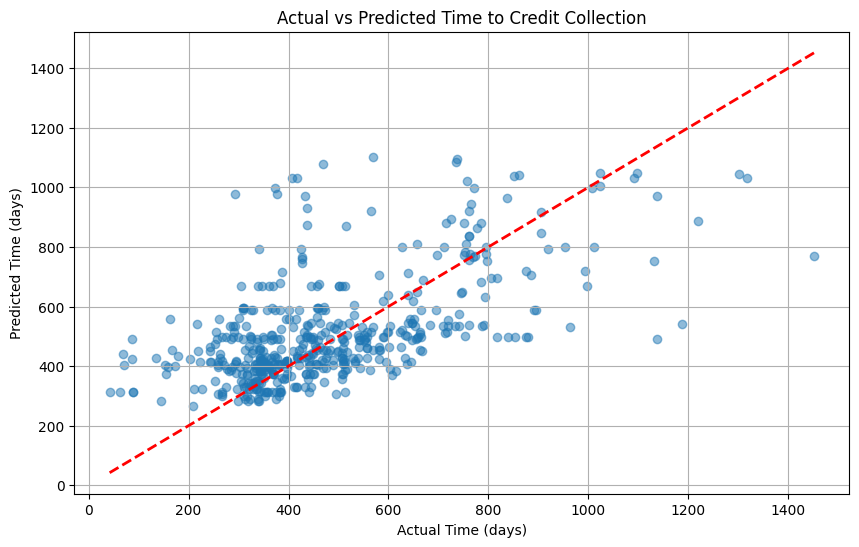

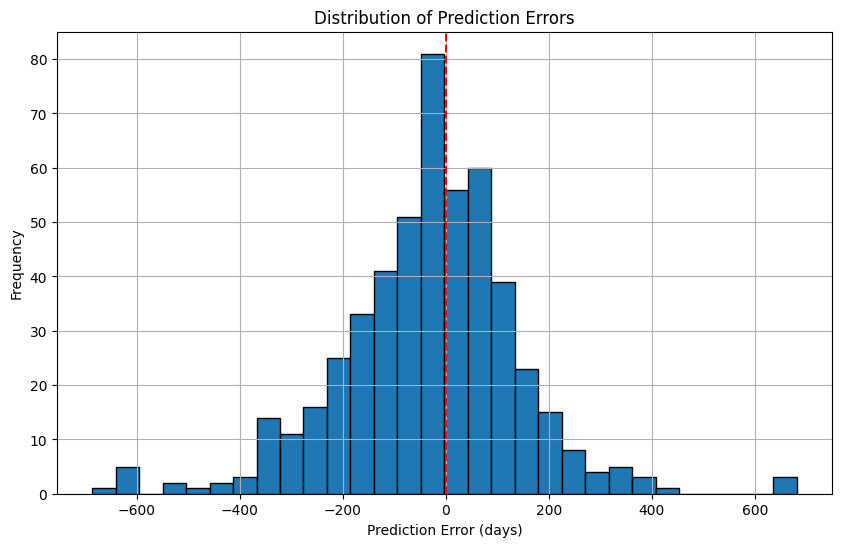

In [ ]:


# Scatter plot: Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Time (days)')
plt.ylabel('Predicted Time (days)')
plt.title('Actual vs Predicted Time to Credit Collection')
plt.grid(True)
plt.show()

# Distribution of errors
errors = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, edgecolor='black')
plt.xlabel('Prediction Error (days)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

## Interpretation